# Article Classification for Structured Archiving : Using Latent Dirichlet Allocation from Gensim library



In [1]:
import wikipedia #for fetching wikipedia articles directly and creating training and testing corpus
import nltk
import re

#### Creating Training Corpus using 10 wikipedia articles from three topics

In [3]:
nltk.download('stopwords')  
#one time download, please comment the code above after first run

#english stop words
en_stop = set(nltk.corpus.stopwords.words('english'))

######################################### FETCHING TRAINING DATA FROM WIKIPEDIA  ##############################################
# articles to TRAIN the LDA model

# Football articles

messi = wikipedia.page("Lionel Messi")
barca = wikipedia.page("FC Barcelona")
rma=wikipedia.page("Real Madrid CF")

# Wildlife articles

lion = wikipedia.page("Lion")
rainforest=wikipedia.page("Rainforest")
plant=wikipedia.page("Plant")
forest=wikipedia.page("Forest")

# Automotive articles
koenigsegg = wikipedia.page("Koenigsegg")
porsche=wikipedia.page("Porsche")
audi=wikipedia.page("Audi")

# Corpus list containing text data of wikipedia pages    
corpus = [messi.content,barca.content,rma.content,
          lion.content,plant.content,rainforest.content,forest.content,
          porsche.content,audi.content,koenigsegg.content
         ]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bucka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Cleaning the Training Corpus

['lionel', 'andrés', 'messi', 'cuccittini', 'spanish']
['futbol', 'club', 'barcelona', 'catalan', 'pronunciation']
['real', 'madrid', 'club', 'fútbol', 'spanish']
['lion', 'panthera', 'specie', 'family', 'felidae']
['plant', 'mainly', 'multicellular', 'predominantly', 'photosynthetic']
['rainforest', 'forest', 'characterized', 'high', 'continuous']
['forest', 'large', 'area', 'dominated', 'tree']
['porsche', 'usually', 'shortened', 'porsche', 'german']
['audi', 'german', 'ʔaːˈɡeː', 'listen', 'german']
['koenigsegg', 'automotive', 'swedish', '¹køːnɪɡsɛɡ', 'listen']


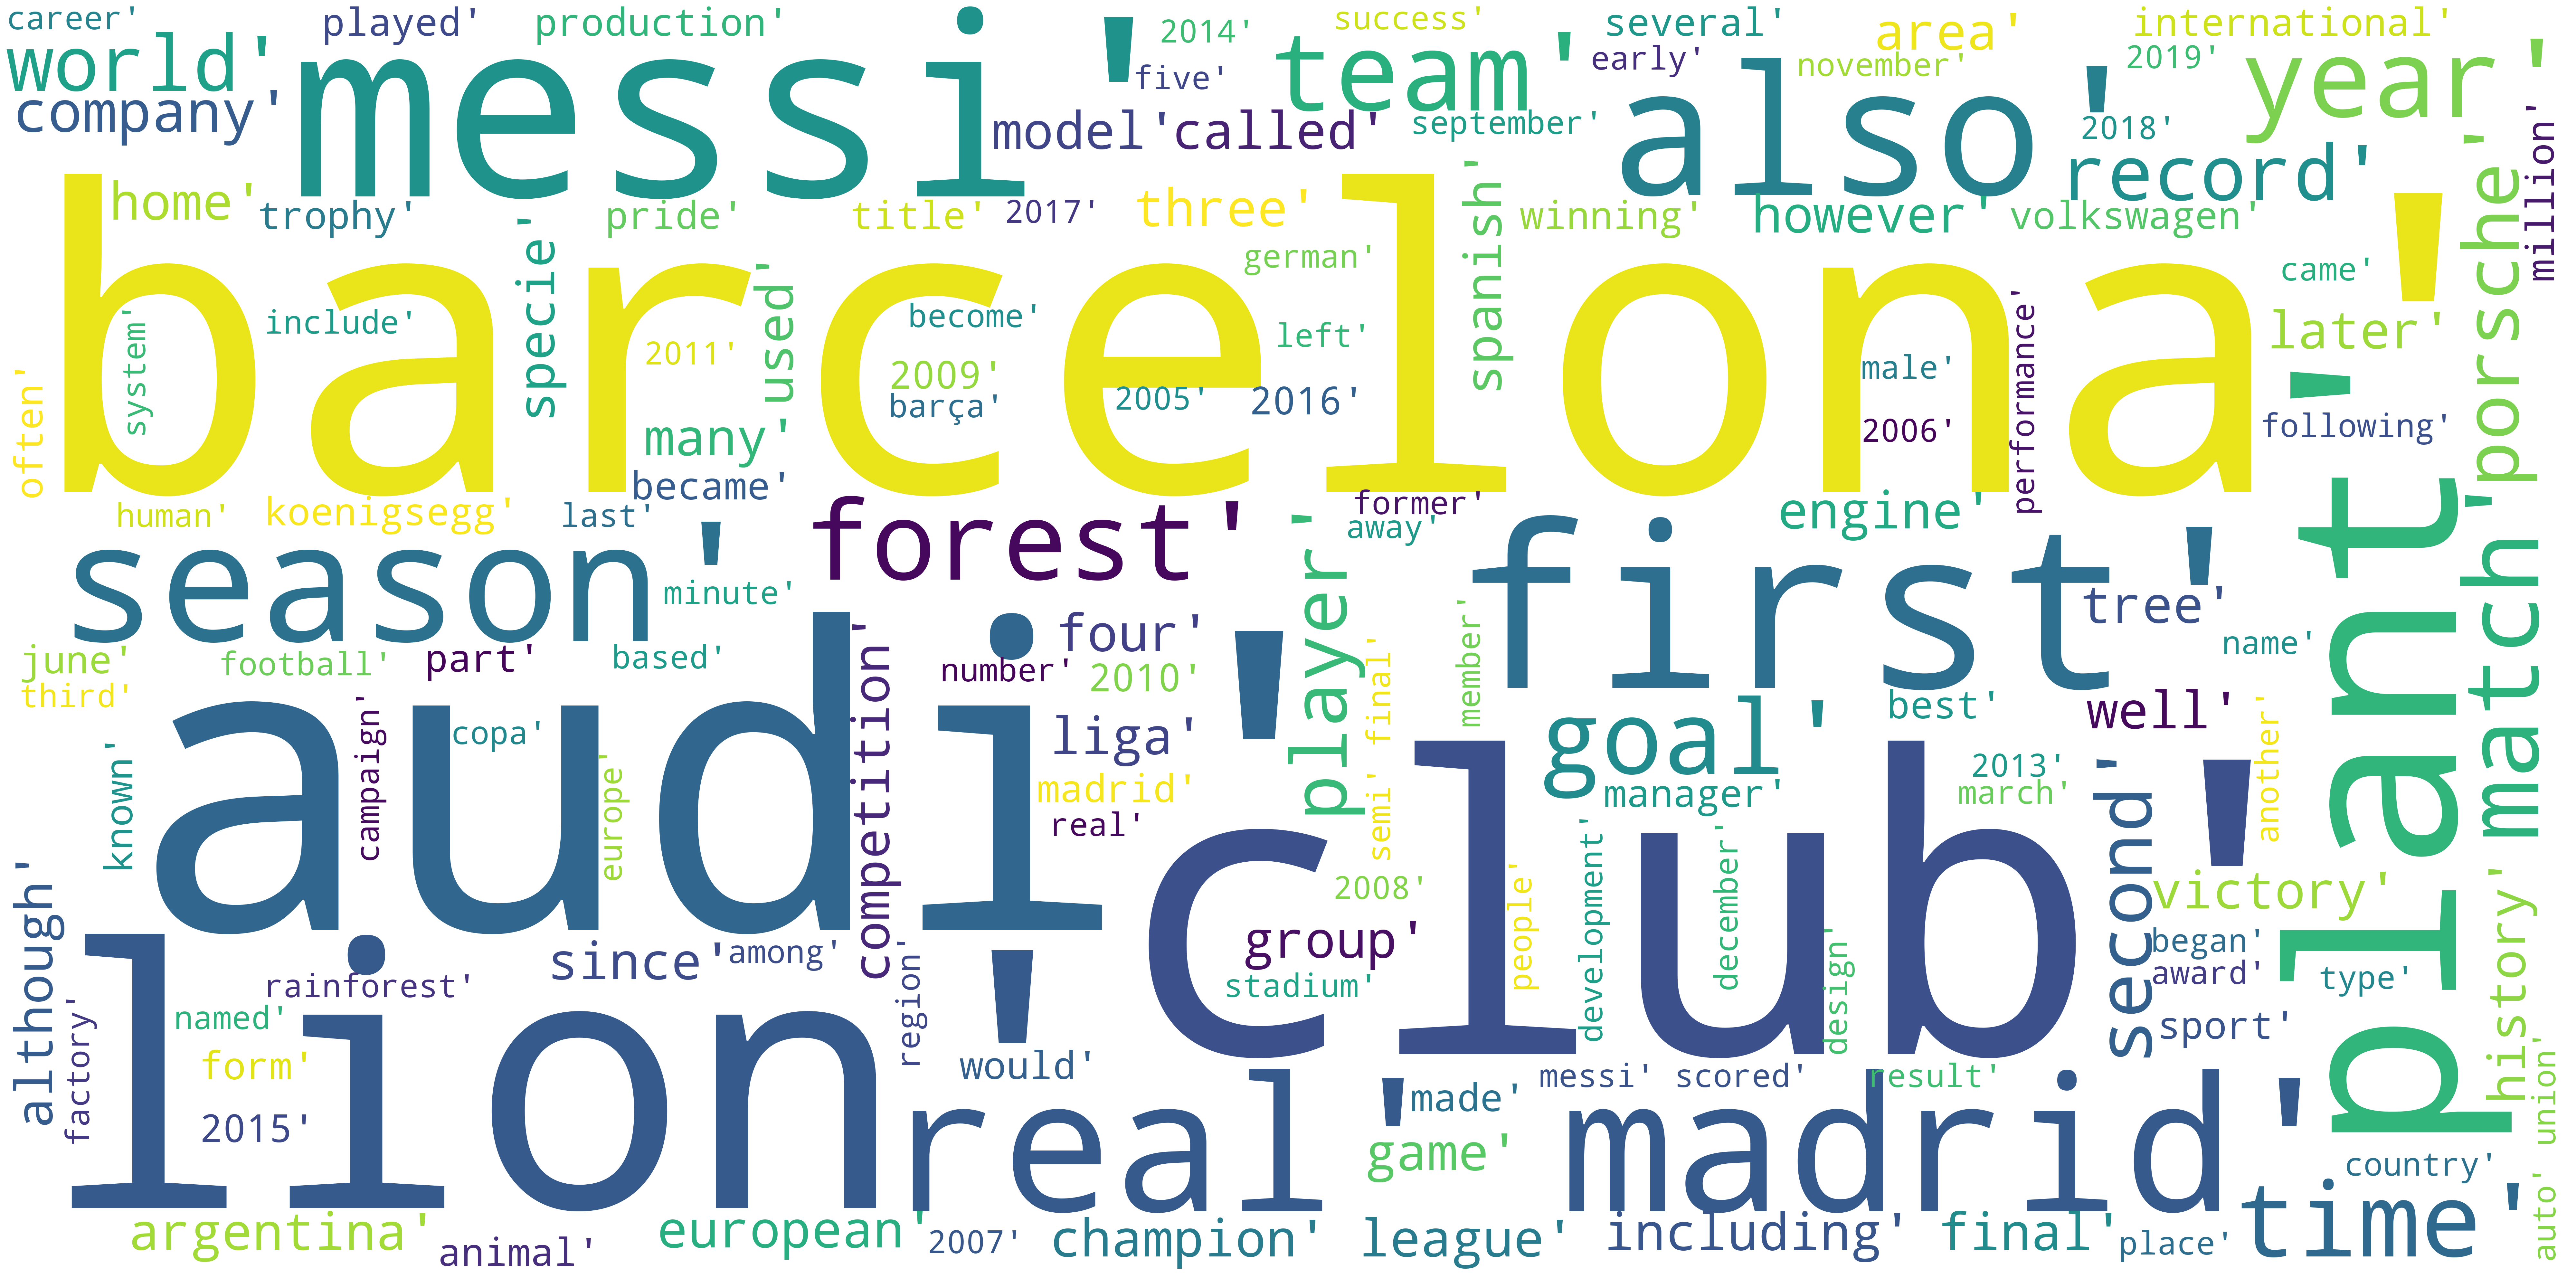

In [4]:
from nltk.stem import WordNetLemmatizer # for lemmatization
stem=WordNetLemmatizer()
def page_data_clean(article):
    article=re.sub(r'\W',' ',str(article))   #replacing special characters with single space
    article=re.sub(r'\s+[a-zA-W]\s+',' ',str(article)) #replacing single character with single space
    article=re.sub(r'\^[a-zA-W]\s+',' ',str(article)) #replacing single characters at the begining with single space
    article=re.sub(r'\s+',' ',str(article)) #replacing multiple space with single space
    article=re.sub(r'^b\s+',' ',str(article)) #removing the prefix at the begining of the wiki articles
    
    article=article.lower() #all characters to lower case
    tokens=article.split()  #spliting to get tokens
    tokens=[stem.lemmatize(word) for word in tokens] #lemmatizing each token 
    tokens=[word for word in tokens if word not in en_stop] #removing english language stop words from the tokens list
    tokens = [word for word in tokens if len(word)  > 3] # removing short tokens 
    
    return tokens

clean_data=[] 
for article in corpus:
    tokens=page_data_clean(article)
    clean_data.append(tokens)
    
for i in range(0,len(clean_data)):
    print(clean_data[i][0:5])
    
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=700, contour_width=110, contour_color='black',scale=20)
wordcloud.generate(str(clean_data))

# Analyzing the frequency of tokens 
wordcloud.to_image()

In [5]:
from gensim import corpora
data_dict=corpora.Dictionary(clean_data) #creating dictionary of the clean tokens
lda_corpus=[data_dict.doc2bow(token,allow_update=False) for token in clean_data] #creating the bag of words 

### Before training the LDA model, let us analyze the model hyperparameters

### K : Number of Topics

In [6]:
import gensim
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
  #  Computing c_v coherence for various number of topics

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(lda_corpus,num_topics=num_topics,id2word=data_dict)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# This will take a little time to execute 
model_list, coherence_values = compute_coherence_values(dictionary=data_dict, corpus=lda_corpus, 
                                                        texts=clean_data, start=1, limit=8, step=1)

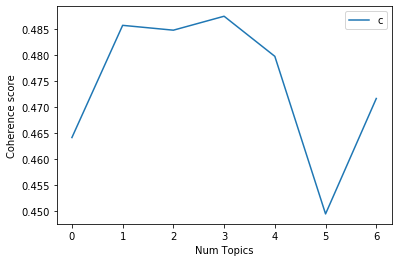

In [7]:
# Graph to select the optimal K
from matplotlib import pyplot as plt
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Dirichlet hyperparameter alpha (α): Document-Topic density

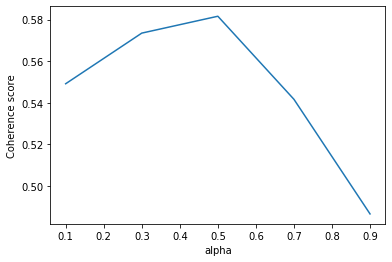

In [8]:
alpha = [0.1,0.3,0.5,0.7,0.9]

c=[]
for a in alpha:
    lda_model1=gensim.models.ldamodel.LdaModel(lda_corpus,num_topics=3,id2word=data_dict,passes=100,alpha=a)
    coherence_model_lda = CoherenceModel(model=lda_model1, texts=clean_data, dictionary=data_dict, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    c.append(coherence_lda)
plt.plot(alpha,c)
plt.xlabel("alpha")
plt.ylabel("Coherence score")
plt.show()

### Dirichlet hyperparameter beta (β): Word-Topic density

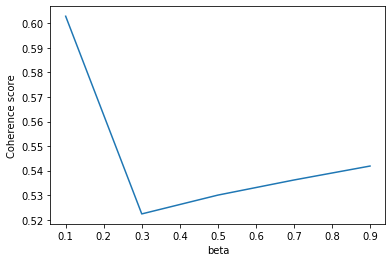

In [9]:

beta = [0.1,0.3,0.5,0.7,0.9]

c=[]
for b in beta:
    lda_model1=gensim.models.ldamodel.LdaModel(lda_corpus,num_topics=3,id2word=data_dict,passes=100,alpha=0.5,eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model1, texts=clean_data, dictionary=data_dict, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    c.append(coherence_lda)
x = [0.1,0.3,0.5,0.7,0.9]
plt.plot(x,c)
plt.xlabel("beta")
plt.ylabel("Coherence score")

plt.show()

# Training LDA model 

In [10]:
import gensim #using LDA model from the open source python library GENSIM
lda_model=gensim.models.ldamodel.LdaModel(lda_corpus,num_topics=3,id2word=data_dict,passes=800)
topics=lda_model.print_topics()


#### Most salient tokens in each topic with their corresponding weight

In [11]:
for topic in topics:
    print(topic,'\n')

(0, '0.031*"lion" + 0.021*"plant" + 0.005*"male" + 0.005*"group" + 0.004*"pride" + 0.004*"year" + 0.004*"africa" + 0.004*"also" + 0.004*"specie" + 0.004*"algae"') 

(1, '0.024*"audi" + 0.015*"forest" + 0.009*"porsche" + 0.007*"engine" + 0.006*"company" + 0.006*"model" + 0.005*"also" + 0.005*"volkswagen" + 0.005*"koenigsegg" + 0.005*"tree"') 

(2, '0.018*"club" + 0.016*"messi" + 0.015*"barcelona" + 0.012*"madrid" + 0.012*"goal" + 0.011*"real" + 0.010*"first" + 0.010*"player" + 0.009*"team" + 0.008*"season"') 



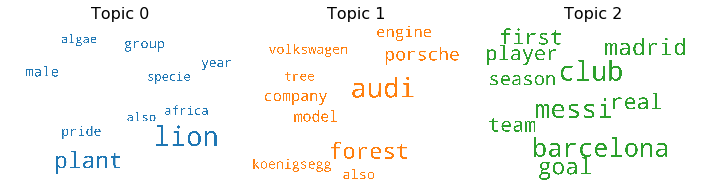

In [12]:
import re
topics=lda_model.print_topics()
p=re.compile(r'\"\w+\"')
topic_dict={}
for topic in topics:
    topic_dict[topic[0]]= re.sub(r'\W',' ',str( p.findall(topic[1])[0]+p.findall(topic[1])[1]+
                                               p.findall(topic[1])[2]+p.findall(topic[1])[3] +
                                              p.findall(topic[1])[4]))
    
#the topic dictionary has the topic number as key and the five most common tokens as its value
topic_dict

#!pip install wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=en_stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
# this dictionary has the three topics as keys and the EXPECTED most common tokens as the values
# this dictionary will be used to identify the topic NAME that each article will be assigned by the LDA model  

act_topic_dict_labels={'Automotive':['audi','porsche','engine','koenigsegg','model','production','company','year'],
                       'Wildlife':['forest','plant','rainforest','tropical','tree','land','specie','algae','tiger',
                                   'area','male'],
                       'Football and Clubs':['club','messi','barcelona','madrid','goal','season','player']}


## LDA model on Training corpus 

Page title :     Lionel Messi
[(2, 0.99992675)]
Assigned Topic  : Football and Clubs


Page title :      FC Barcelona
[(2, 0.9998584)]
Assigned Topic  : Football and Clubs


Page title :     Real Madrid CF
[(2, 0.9998535)]
Assigned Topic  : Football and Clubs


Page title :     Lion
[(0, 0.99984705)]
Assigned Topic  : Wildlife


Page title :     Rainforest
[(1, 0.99942744)]
Assigned Topic  : Automotive


Page title :     Plant
[(0, 0.9998026)]
Assigned Topic  : Wildlife


Page title :     Forest
[(1, 0.99968493)]
Assigned Topic  : Automotive


Page title :     Koenigsegg
[(1, 0.9994433)]
Assigned Topic  : Automotive


Page title :     Porsche
[(1, 0.9995804)]
Assigned Topic  : Automotive


Page title :     Audi
[(1, 0.9998606)]
Assigned Topic  : Automotive




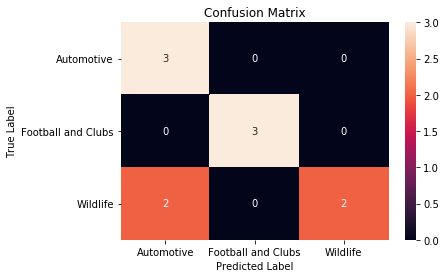

In [14]:
# we run our trained on our training data points 

test_articles_dict={       'Lionel Messi':'Football and Clubs',
                           ' FC Barcelona':'Football and Clubs',
                           "Real Madrid CF":'Football and Clubs',
                           "Lion":'Wildlife', "Rainforest":'Wildlife',
                           "Plant":'Wildlife', "Forest":'Wildlife',
                          "Koenigsegg":'Automotive', "Porsche":'Automotive',
                          "Audi":'Automotive' 
}
known_class=[]  # this list holds the correct class of each article, we append the correct class for each article
model_class_article=[] #this list holds the class that the LDA model allocated to the article
dict1={}
for page_title,known_class_label in test_articles_dict.items():
    unseen_page=wikipedia.page(page_title)
    unseen_article=  unseen_page.content
    test_data=page_data_clean(unseen_article)
    BOW_test_data=data_dict.doc2bow(test_data)
    print("Page title :    ",page_title)
    print(lda_model.get_document_topics(BOW_test_data))

    known_class.append(known_class_label)

# the below lengthy code assigns each article to one of the three topics
# NOTE LDA model does not explicitly perform the categorization of articles
# instead the LDA model gives the probability of an article to belong to the topics
# so we had to explicitly assign each article to its most probable topic
    import pandas as pd

    t1=[]
    t2=[]
    for topic_probability in lda_model.get_document_topics(BOW_test_data):
        t1.append(topic_probability[0])
        t2.append(topic_probability[1])

    df=pd.DataFrame({'topic_index':t1,'topic_prob':t2})
    df=df.sort_values('topic_prob',ascending =False)
    model_class=df.iloc[0,0]
    i=0
    model_class_labels=topic_dict[model_class]
    #print(model_class_labels)
    for x,y in act_topic_dict_labels.items():
        dict1[x]=0
    for x,y in act_topic_dict_labels.items():
        for label in model_class_labels.split():
            if label in y:
                dict1[x]+=1
    import pandas as pd
    pd.DataFrame(dict1,index=dict1.keys())
    key=[i for i in dict1.keys()]
    val=[i for i in dict1.values()]
    df_for_label=pd.DataFrame({'k':key,'v':val})

    df_for_label=df_for_label.sort_values('v',ascending=False)
    df_for_label
    print('Assigned Topic  :',df_for_label.iloc[0,0])
    model_class_article.append(df_for_label.iloc[0,0])
    print('\n')
    
#Confusion Matrix 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(known_class,model_class_article)
cm
class_label = ['Automotive','Football and Clubs','Wildlife']
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Model Testing 

## Testing the Model on 29 different Wikipedia articles from the three topics
### Note : The model was trained on 10 wikipedia articles

Page title    : Diego Maradona
[(0, 0.037747934), (1, 0.07894353), (2, 0.8833085)]
Assigned topic :   Football and Clubs


Page title    : Arsène Wenger
[(0, 0.037629608), (1, 0.090097174), (2, 0.87227327)]
Assigned topic :   Football and Clubs


Page title    : Alessandro Del Piero
[(0, 0.01686295), (1, 0.051320616), (2, 0.9318164)]
Assigned topic :   Football and Clubs


Page title    : Francesco Totti
[(1, 0.05356892), (2, 0.9421494)]
Assigned topic :   Football and Clubs


Page title    : A.S. Roma
[(0, 0.017360788), (1, 0.13637386), (2, 0.8462653)]
Assigned topic :   Football and Clubs


Page title    : Premier League
[(0, 0.014200405), (1, 0.121930614), (2, 0.863869)]
Assigned topic :   Football and Clubs


Page title    : El Clásico
[(0, 0.024524225), (1, 0.020833418), (2, 0.95464236)]
Assigned topic :   Football and Clubs


Page title    : UEFA Champions League
[(0, 0.01817014), (1, 0.13047762), (2, 0.8513523)]
Assigned topic :   Football and Clubs


Page title    : Industrial 

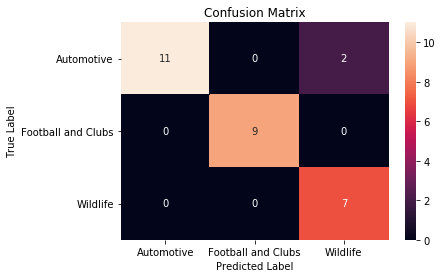

In [18]:
test_articles_dict={'Diego Maradona':'Football and Clubs','Arsène Wenger':'Football and Clubs',
                           'Alessandro Del Piero':'Football and Clubs',
                           'Francesco Totti':'Football and Clubs',
                           'A.S. Roma':'Football and Clubs','Premier League':'Football and Clubs',
                    'El Clásico':'Football and Clubs','UEFA Champions League':'Football and Clubs',
                    'Industrial Revolution':'Wildlife','L\'Équipe':'Football and Clubs',
                    'Photosynthesis':'Wildlife','Global warming':'Wildlife',
                           'Lion':'Wildlife','Snake':'Wildlife','Hyena':'Wildlife',
                           'Species':'Wildlife', 'Cheetah':'Wildlife','Rhinoceros':'Wildlife',
                    'Ferrari':'Automotive','Toyota':'Automotive', 'Mercedes-Benz':'Automotive',
                    'Subaru':'Automotive','Formula One':'Automotive','Aerodynamics':'Automotive',
                    'Fluid dynamics':'Automotive','V12 engine':'Automotive','Camshaft':'Automotive',
                    'Fuel injection':'Automotive','Petrol engine':'Automotive'
                       
}
known_class=[]  # this list holds the correct class of each article, we append the correct class for each article
model_class_article=[] #this list holds the class that the LDA model allocated to the article
dict1={}
for page_title,known_class_label in test_articles_dict.items():
    unseen_page=wikipedia.page(page_title)
    unseen_article=  unseen_page.content
    test_data=page_data_clean(unseen_article)
    BOW_test_data=data_dict.doc2bow(test_data)
    print("Page title    :",page_title)
    print(lda_model.get_document_topics(BOW_test_data))

    known_class.append(known_class_label)


    import pandas as pd

    t1=[]
    t2=[]
    for topic_probability in lda_model.get_document_topics(BOW_test_data):
        t1.append(topic_probability[0])
        t2.append(topic_probability[1])

    df=pd.DataFrame({'topic_index':t1,'topic_prob':t2})
    df=df.sort_values('topic_prob',ascending =False)
    model_class=df.iloc[0,0]
    i=0
    model_class_labels=topic_dict[model_class]
    #print(model_class_labels)
    for x,y in act_topic_dict_labels.items():
        dict1[x]=0
    for x,y in act_topic_dict_labels.items():
        for label in model_class_labels.split():
            if label in y:
                dict1[x]+=1
    import pandas as pd
    pd.DataFrame(dict1,index=dict1.keys())
    key=[i for i in dict1.keys()]
    val=[i for i in dict1.values()]
    df_for_label=pd.DataFrame({'k':key,'v':val})

    df_for_label=df_for_label.sort_values('v',ascending=False)
    df_for_label
    print('Assigned topic :  ',df_for_label.iloc[0,0])
    model_class_article.append(df_for_label.iloc[0,0])
    print('\n')
    
#Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(model_class_article,known_class)
cm
class_label = ['Automotive','Football and Clubs','Wildlife']
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(lda_corpus))  # a measure of how good the modelis, lower the better.
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_data, dictionary=data_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.67136278873507

Coherence Score:  0.5816302168806938


### Generic Baseline LDA model for comparison 

In [16]:
# this is the baseline model, this is to compare the performance of our trained LDA model
lda_model1=gensim.models.ldamodel.LdaModel(lda_corpus,id2word=data_dict)
topics=lda_model1.print_topics()
# Compute Perplexity
print('\nPerplexity: ', lda_model1.log_perplexity(lda_corpus))  # a measure of how good the model is. lower the better.
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model1, texts=clean_data, dictionary=data_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -20.888439845743363

Coherence Score:  0.45745608636211094


### Our trained LDA model has higher Coherence score and much lower Perplexity value, compared to the Baseline model above. Also the results generated by our LDA model are much more interpretable.

# Statistical Summary of the Trained LDA model

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(model_class_article,known_class))
print(accuracy_score(model_class_article,known_class))

                    precision    recall  f1-score   support

        Automotive       1.00      0.85      0.92        13
Football and Clubs       1.00      1.00      1.00         9
          Wildlife       0.78      1.00      0.88         7

          accuracy                           0.93        29
         macro avg       0.93      0.95      0.93        29
      weighted avg       0.95      0.93      0.93        29

0.9310344827586207


# Our model has accuracy of 93.1%